# EDA

## Task
Xente is an e-commerce and financial service app serving 10,000+ customers in Uganda.
Xente offers smart Visa cards & payment solutions that simplify finance and admin for companies operating in Africa.
This dataset includes a sample of approximately 140,000 transactions that occurred between 15 November 2018 and 15 March 2019.

One of the challenges of fraud detection problems is that the data is highly imbalanced. See these blogs for examples on how imbalanced data might be handled:
https://medium.com/coinmonks/handling-imbalanced-datasets-predicting-credit-card-fraud-544f5e74e0fd
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

## Variables
Column Name,Definition
* TransactionId: Unique transaction identifier on platform
* BatchId: Unique number assigned to a batch of transactions for processing
* AccountId: Unique number identifying the customer on platform
* SubscriptionId: Unique number identifying the customer subscription
* CustomerId: Unique identifier attached to Account
* CurrencyCode: Country currency
* CountryCode: Numerical geographical code of country
* ProviderId: Source provider of Item bought.
* ProductId: Item name being bought.
* ProductCategory: ProductIds are organized into these broader product categories.
* ChannelId: "Identifies if customer used web,Android, IOS, pay later or checkout."
* Amount: Value of the transaction. Positive for debits from customer account and negative for credit into customer account
* Value: Absolute value of the amount
* TransactionStartTime: Transaction start time
* PricingStrategy,: Category of Xente's pricing structure for merchants
* FraudResult: Fraud status of transaction 1 -yes or 0-No

## Brainstorming
* new feature: sign of "Amount" to separate debit from credit transactions
* |Amount| should be == value -> not always the case!
* After baseline modeling: Feature engineering on TransactionStartTime
    * Periodicality (more fraud during/after work hours, certain days of the week...)

## Import libraries

In [57]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

import ipywidgets

import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef
from imblearn.over_sampling import SMOTE

## Import data

In [2]:
df = pd.read_csv("../data/training.csv")
df = df.drop(["CurrencyCode","CountryCode"], axis=1) # identical value across all entries
df.set_index("TransactionId", inplace=True)
df.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


## Profiling report

In [3]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Exploratory Data Analysis

## Plot fraudulent transactions for all features

In [4]:
fraud = df.query("FraudResult == 1")
fraud

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,
TransactionId_60873,BatchId_93685,AccountId_3832,SubscriptionId_4161,CustomerId_4275,ProviderId_3,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-15T08:04:51Z,0,1
TransactionId_28016,BatchId_125553,AccountId_2366,SubscriptionId_4834,CustomerId_7414,ProviderId_5,ProductId_9,financial_services,ChannelId_1,725000.0,725000,2018-11-15T08:20:09Z,2,1
TransactionId_1149,BatchId_10381,AccountId_3832,SubscriptionId_4161,CustomerId_4275,ProviderId_3,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-15T08:31:57Z,0,1
TransactionId_136904,BatchId_52644,AccountId_3692,SubscriptionId_3451,CustomerId_4134,ProviderId_1,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-17T09:15:23Z,0,1
TransactionId_88818,BatchId_54481,AccountId_3832,SubscriptionId_4161,CustomerId_4275,ProviderId_3,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-17T11:49:46Z,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TransactionId_69673,BatchId_111976,AccountId_4687,SubscriptionId_4160,CustomerId_5155,ProviderId_3,ProductId_15,financial_services,ChannelId_3,2000000.0,2000000,2019-02-12T14:00:41Z,2,1
TransactionId_128664,BatchId_128748,AccountId_1909,SubscriptionId_2496,CustomerId_2303,ProviderId_6,ProductId_3,airtime,ChannelId_3,500000.0,500000,2019-02-12T18:07:11Z,2,1
TransactionId_33086,BatchId_40160,AccountId_1909,SubscriptionId_2496,CustomerId_2303,ProviderId_3,ProductId_15,financial_services,ChannelId_3,500000.0,500000,2019-02-12T21:31:21Z,2,1


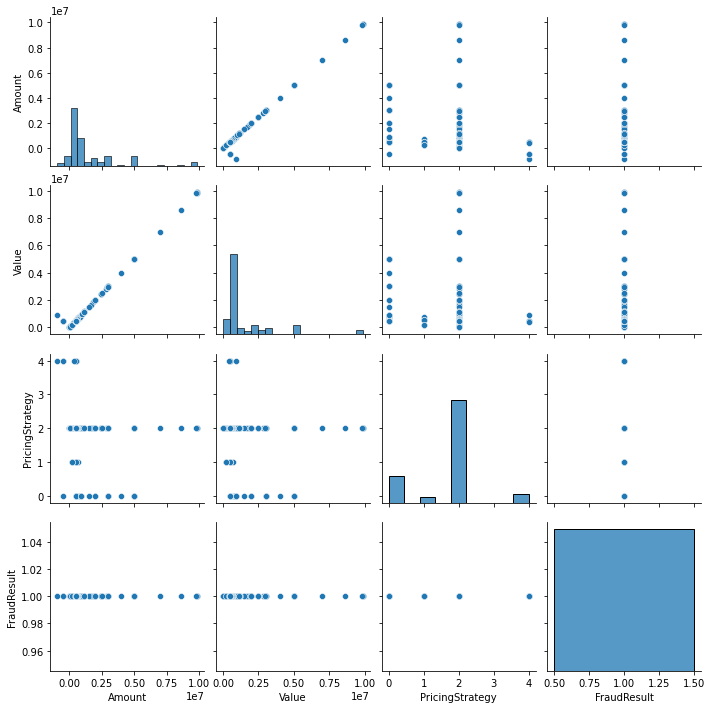

In [5]:
sns.pairplot(fraud)

36

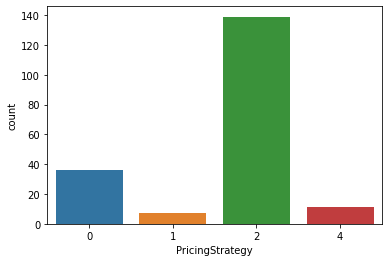

In [6]:
sns.countplot(x="PricingStrategy", data=fraud)
plt.show

fraud.query("PricingStrategy == 0")["PricingStrategy"].count()

Analysing fraud-positive data, we can see a high correlation with pricingstrategy = 0 (10% fraud-positive)

## Normalize fraudulent transactions against ProductID

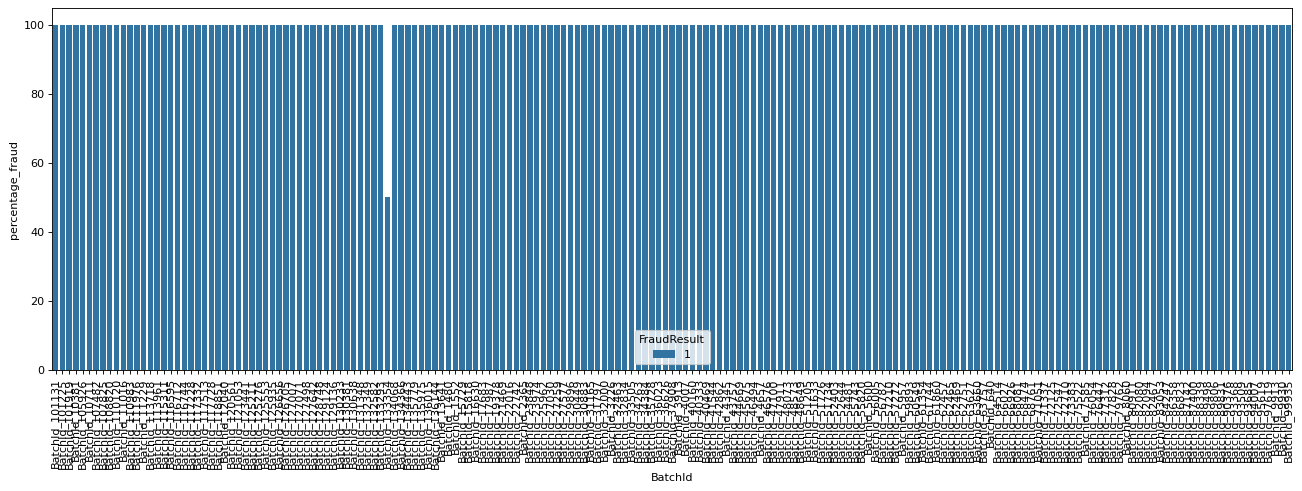

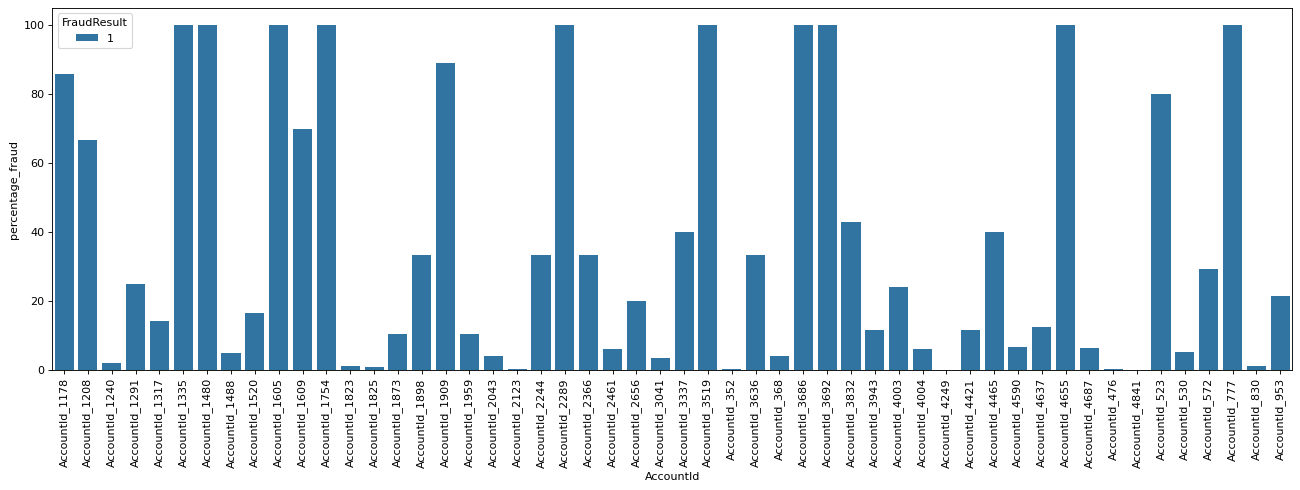

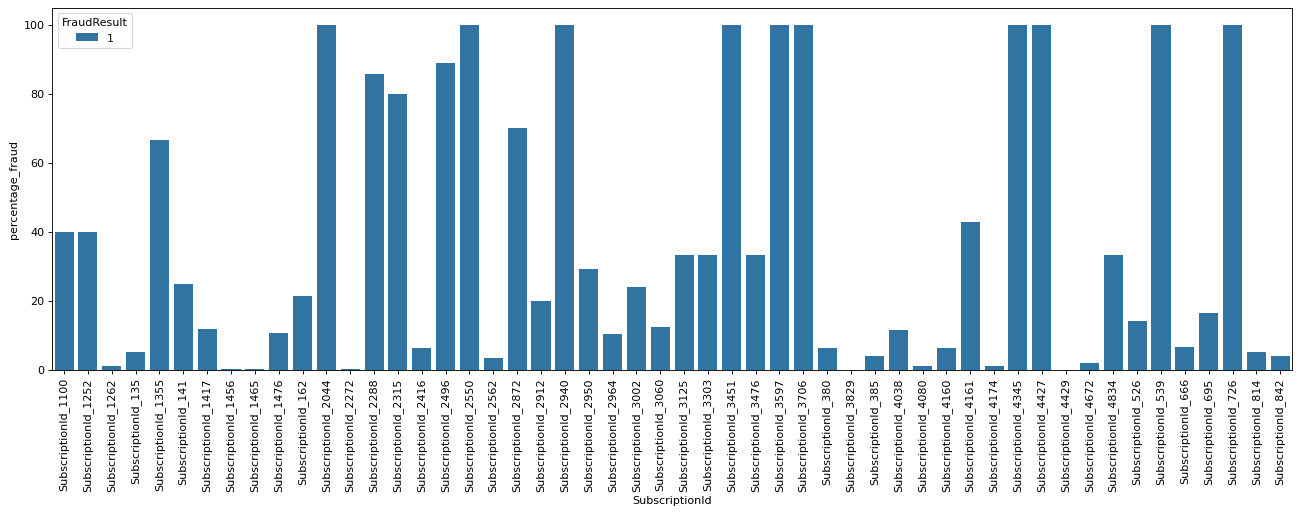

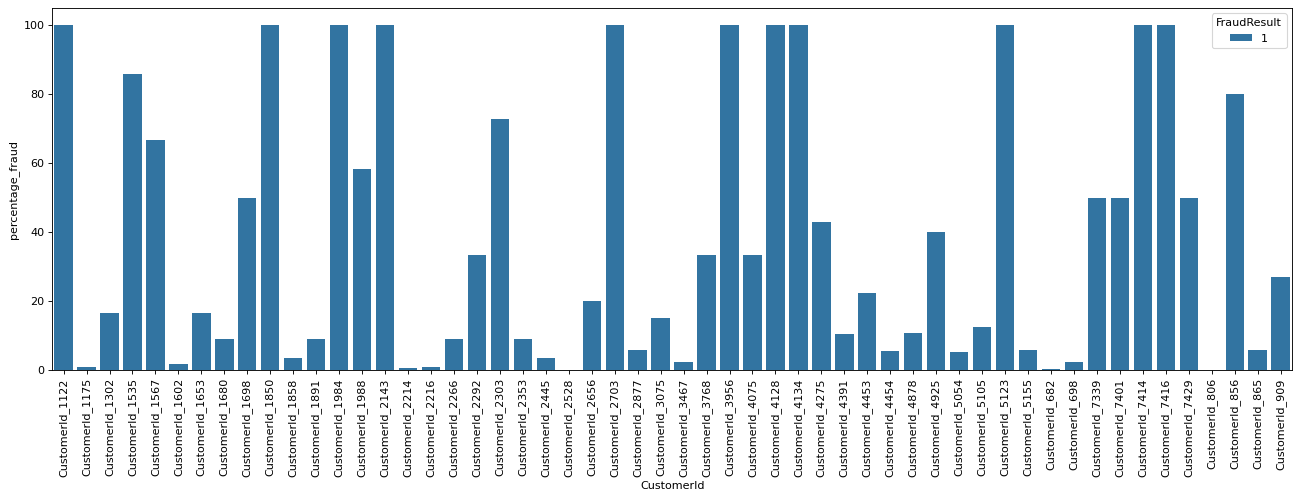

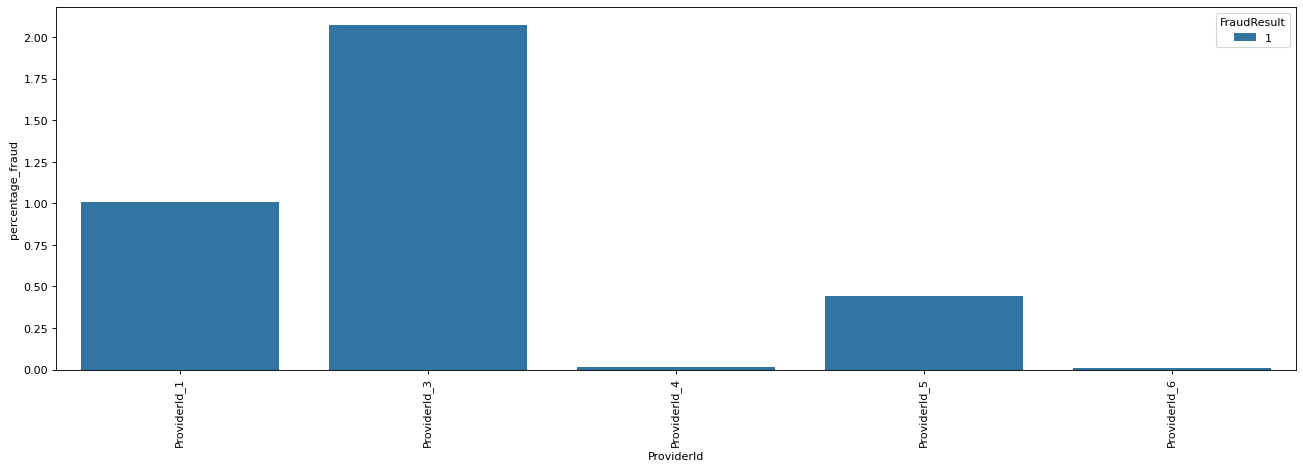

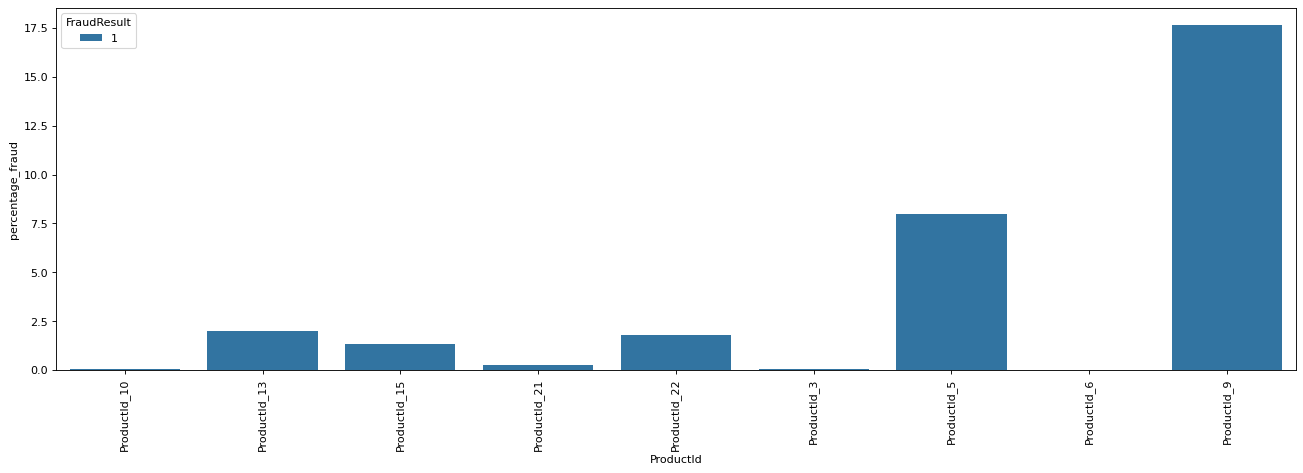

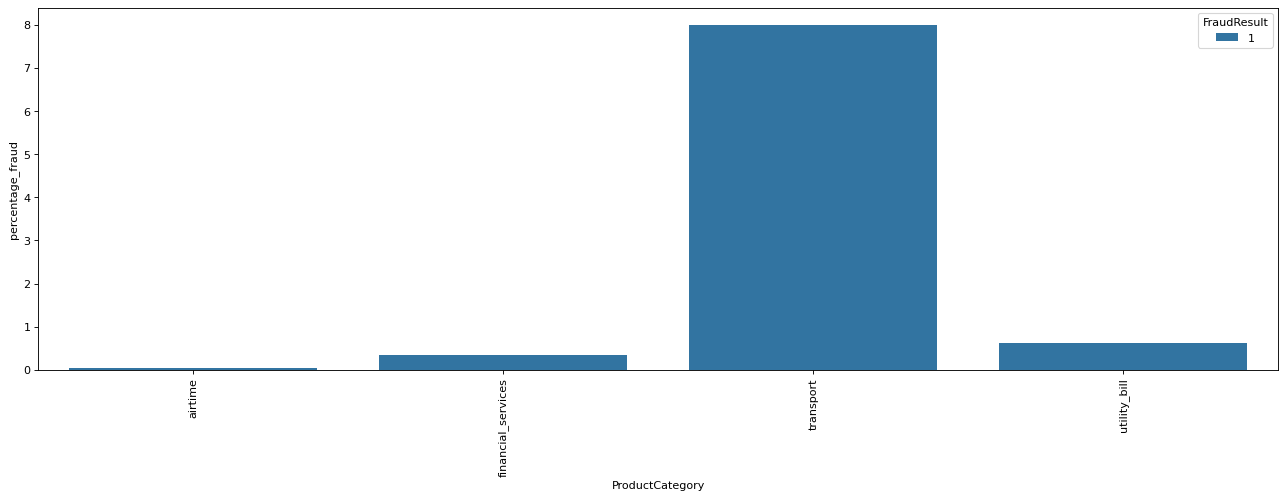

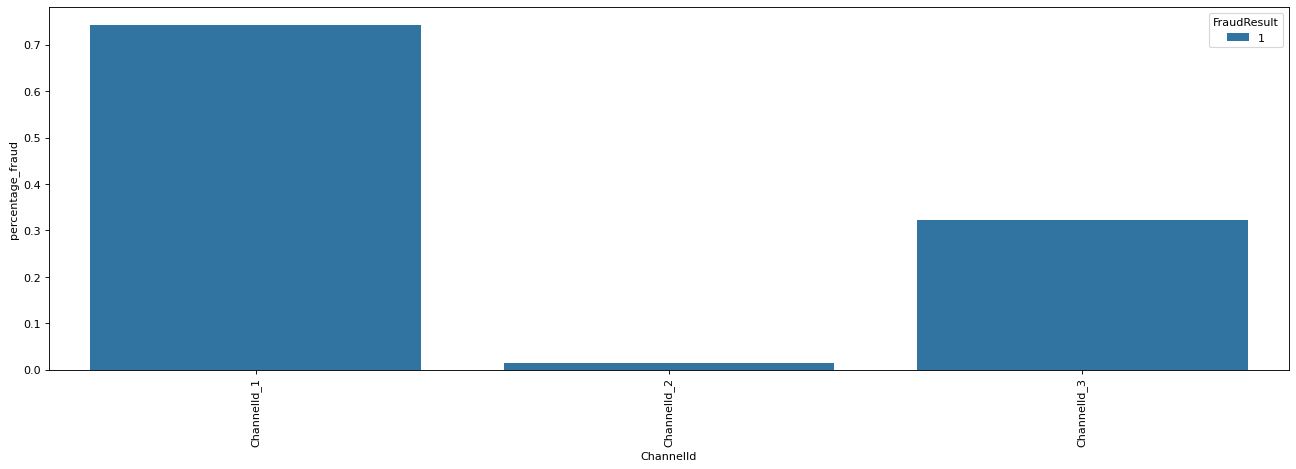

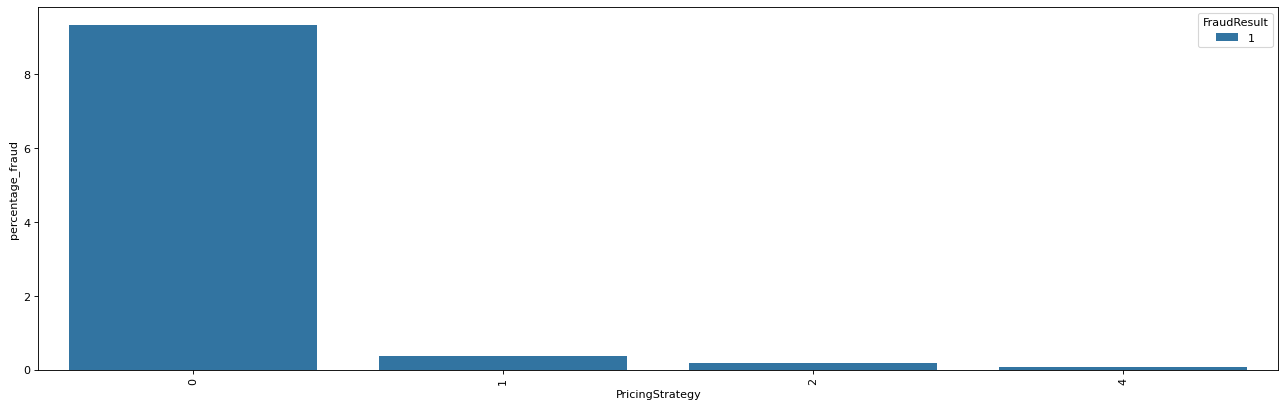

In [7]:
feature_names = ['BatchId',
 'AccountId',
 'SubscriptionId',
 'CustomerId',
 'ProviderId',
 'ProductId',
 'ProductCategory',
 'ChannelId',
 'PricingStrategy']

for feat in feature_names:
    counts = (df.groupby(feat)['FraudResult']
                         .value_counts(normalize=True)
                         .rename('percentage_fraud')
                         .mul(100)
                         .reset_index()
                         .sort_values(feat))
    plt.figure(figsize=(20,6), dpi=80)
    p = sns.barplot(x=feat, y="percentage_fraud", hue="FraudResult", data=counts[counts.FraudResult==1])
    plt.xticks(rotation=90)

## Get dummies
Use pd.get_dummies(loans,columns=cat_feats,drop_first=True) to create a fixed larger dataframe that has new feature columns with dummy variables. Set this dataframe as final_data.**

In [8]:
df.columns.tolist()

['BatchId',
 'AccountId',
 'SubscriptionId',
 'CustomerId',
 'ProviderId',
 'ProductId',
 'ProductCategory',
 'ChannelId',
 'Amount',
 'Value',
 'TransactionStartTime',
 'PricingStrategy',
 'FraudResult']

In [9]:
cat_columns = [
 'ProviderId',
 'ProductId',
 'ProductCategory',
 'ChannelId',
 'PricingStrategy']

In [10]:
df_dummies = pd.get_dummies(df, columns=cat_columns, drop_first = True)
df_dummies.head()

baseline = df_dummies.drop(["BatchId", "AccountId", "SubscriptionId", "CustomerId", "TransactionStartTime"], axis=1)

### Define features (X) and target variable (y)

In [11]:
X = baseline.loc[:, baseline.columns != 'FraudResult']
y = baseline["FraudResult"]

In [18]:
RSEED = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RSEED)

## Baseline model Decision tree

In [13]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)   

confusion_matrix(y_test, predictions)

array([[28636,     5],
       [   13,    45]])

In [14]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.90      0.78      0.83        58

    accuracy                           1.00     28699
   macro avg       0.95      0.89      0.92     28699
weighted avg       1.00      1.00      1.00     28699



## Comparing dtree base line model with Naive Bayes

In [15]:
NB = GaussianNB()
NB.fit(X_test, y_test)

GaussianNB()

In [16]:
predictions = NB.predict(X_test)   
confusion_matrix(y_test, predictions)

array([[28532,   109],
       [    7,    51]])

In [64]:
print(classification_report(y_test, predictions))

print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.64      0.91      0.75        58

    accuracy                           1.00     28699
   macro avg       0.82      0.96      0.88     28699
weighted avg       1.00      1.00      1.00     28699

Matthew Coefficient:


0.7633335473980633

## Balancing with SMOTE

In [29]:
# Generate synthetic samples
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

dtree = DecisionTreeClassifier()
dtree.fit(X_train_balanced,y_train_balanced)
predictions_dtree_sm = dtree.predict(X_test)   

In [63]:
print(confusion_matrix(y_test, predictions_dtree_sm))
print(classification_report(y_test, predictions_dtree_sm))

print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions_dtree_sm) 

[[28612    29]
 [    5    53]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.65      0.91      0.76        58

    accuracy                           1.00     28699
   macro avg       0.82      0.96      0.88     28699
weighted avg       1.00      1.00      1.00     28699

Matthew Coefficient:


0.7679898739559775

## Random Forest

In [33]:
RandomForest_sm = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

RandomForest_sm.fit(X_train_balanced, y_train_balanced)
predictions_RandomForest_sm = RandomForest_sm.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [62]:
print(confusion_matrix(y_test, predictions_RandomForest_sm))
print(classification_report(y_test, predictions_RandomForest_sm))

print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions_RandomForest_sm)

[[28610    31]
 [    7    51]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.62      0.88      0.73        58

    accuracy                           1.00     28699
   macro avg       0.81      0.94      0.86     28699
weighted avg       1.00      1.00      1.00     28699

Matthew Coefficient:


0.7389182229435233

### Random Forest Optimization through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. 

In [65]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 1000, 10).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# Fit 
rs.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                      

In [66]:
rs.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'max_leaf_nodes': 33,
 'max_features': 0.6,
 'max_depth': 6,
 'bootstrap': False}

In [68]:
RandomForest_sm_opt = RandomForestClassifier(n_estimators=1000, 
                                random_state=RSEED, 
                                min_samples_split = 5,
                                max_features = 0.6,
                                max_leaf_nodes = 33,
                                max_depth = 6,
                                bootstrap = False,             
                                n_jobs=-1, verbose = 1)

RandomForest_sm_opt.fit(X_train_balanced, y_train_balanced)
predictions_RandomForest_sm_opt = RandomForest_sm_opt.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[CV 1/3] END bootstrap=True, max_depth=8, max_features=0.5, max_leaf_nodes=25, min_samples_split=10, n_estimators=450;, score=1.000 total time=  23.2s
[CV 1/3] END bootstrap=False, max_depth=15, max_features=0.5, max_leaf_nodes=41, min_samples_split=5, n_estimators=560;, score=1.000 total time=  45.8s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=0.5, max_leaf_nodes=12, min_samples_split=2, n_estimators=340;, score=1.000 total time=  25.4s
[CV 1/3] END bootstrap=False, max_depth=15, max_features=sqrt, max_leaf_nodes=42, min_samples_split=2, n_estimators=1000;, score=1.000 total time=  45.8s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, max_leaf_nodes=47, min_samples_split=10, n_estimators=450;, score=1.000 total time=  17.0s
[CV 1/3] END bootstrap=True, max_depth=17, max_features=0.8999999999999999, max_leaf_nodes=16, min_samples_split=2, n_estimators=1000;, score=0.999 total time= 1.3min
[CV 3/3] END bootstrap=False, max_depth=15, max_features=sqrt, max_leaf_

In [73]:
print(confusion_matrix(y_test, predictions_RandomForest_sm_opt))
print(classification_report(y_test, predictions_RandomForest_sm_opt))

print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions_RandomForest_sm_opt)

[[28502   139]
 [    2    56]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.29      0.97      0.44        58

    accuracy                           1.00     28699
   macro avg       0.64      0.98      0.72     28699
weighted avg       1.00      1.00      1.00     28699

Matthew Coefficient:


0.5251814983596657

## Logistic Regression

In [53]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

predictions_LogReg_sm = log_reg.predict(X_test)

In [60]:
# Evaluate the model with a confusion matrix
print(confusion_matrix(y_test, predictions_LogReg_sm))
print(classification_report(y_test, predictions_LogReg_sm))
print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions_LogReg_sm)

[[    0 28641]
 [    0    58]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28641
           1       0.00      1.00      0.00        58

    accuracy                           0.00     28699
   macro avg       0.00      0.50      0.00     28699
weighted avg       0.00      0.00      0.00     28699

Matthew Coefficient:


/Users/tobiasengbring/neuefische/ds-ml-project-zindi-fraud-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tobiasengbring/neuefische/ds-ml-project-zindi-fraud-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tobiasengbring/neuefische/ds-ml-project-zindi-fraud-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

0.0

## Stacking Ensemble

## Code for checking best model regarding F1 Score

In [70]:
from sklearn.metrics import f1_score, make_scorer

In [74]:
f1 = make_scorer(f1_score)

In [88]:
recall = make_scorer(recall)

NameError: name 'recall' is not defined

In [77]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 1000, 10).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                         cv = 3, n_iter = 10, verbose = 5, random_state=RSEED, scoring=f1)

# Fit 
rs.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                      

In [78]:
rs.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'max_leaf_nodes': 42,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [79]:
RandomForest_sm_opt = RandomForestClassifier(n_estimators=1000, 
                                random_state=RSEED, 
                                min_samples_split = 2,
                                max_features = 'sqrt',
                                max_leaf_nodes = 42,
                                max_depth = 15,
                                bootstrap = False,             
                                n_jobs=-1, verbose = 1)

RandomForest_sm_opt.fit(X_train_balanced, y_train_balanced)
predictions_RandomForest_sm_opt = RandomForest_sm_opt.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [80]:
print(confusion_matrix(y_test, predictions_RandomForest_sm_opt))
print(classification_report(y_test, predictions_RandomForest_sm_opt))

print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions_RandomForest_sm_opt)

[[28589    52]
 [    5    53]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.50      0.91      0.65        58

    accuracy                           1.00     28699
   macro avg       0.75      0.96      0.82     28699
weighted avg       1.00      1.00      1.00     28699

Matthew Coefficient:


0.6783598176649033

In [81]:
matthew = make_scorer(matthews_corrcoef)

[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, max_leaf_nodes=47, min_samples_split=10, n_estimators=450;, score=0.998 total time=  17.1s
[CV 2/3] END bootstrap=True, max_depth=17, max_features=0.8999999999999999, max_leaf_nodes=16, min_samples_split=2, n_estimators=1000;, score=0.997 total time= 1.3min
[CV 2/3] END bootstrap=False, max_depth=15, max_features=sqrt, max_leaf_nodes=42, min_samples_split=2, n_estimators=1000;, score=0.999 total time=  41.6s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, max_leaf_nodes=47, min_samples_split=10, n_estimators=450;, score=0.998 total time=  17.1s
[CV 1/3] END bootstrap=True, max_depth=17, max_features=0.8999999999999999, max_leaf_nodes=16, min_samples_split=2, n_estimators=1000;, score=0.995 total time= 1.3min
[CV 3/3] END bootstrap=False, max_depth=15, max_features=sqrt, max_leaf_nodes=42, min_samples_split=2, n_estimators=1000;, score=0.999 total time=  41.9s
[CV 1/3] END bootstrap=True, max_depth=6, max_featur

In [82]:
rs_matthew = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                         cv = 3, n_iter = 10, verbose = 5, random_state=RSEED, scoring=matthew)

# Fit 
rs_matthew.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                      

In [83]:
rs_matthew.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'max_leaf_nodes': 42,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [84]:
RandomForest_sm_opt_matthew = RandomForestClassifier(n_estimators=1000, 
                                random_state=RSEED, 
                                min_samples_split = 2,
                                max_features = 'sqrt',
                                max_leaf_nodes = 42,
                                max_depth = 15,
                                bootstrap = False,             
                                n_jobs=-1, verbose = 1)

RandomForest_sm_opt_matthew.fit(X_train_balanced, y_train_balanced)
predictions_RandomForest_sm_opt = RandomForest_sm_opt_matthew.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [85]:
print(confusion_matrix(y_test, predictions_RandomForest_sm_opt))
print(classification_report(y_test, predictions_RandomForest_sm_opt))

print("Matthew Coefficient:") 
matthews_corrcoef(y_test, predictions_RandomForest_sm_opt)

[[28589    52]
 [    5    53]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.50      0.91      0.65        58

    accuracy                           1.00     28699
   macro avg       0.75      0.96      0.82     28699
weighted avg       1.00      1.00      1.00     28699

Matthew Coefficient:


0.6783598176649033

## Creating a function to compare all models (dtree Baseline, RandomForest, Logistic Regression)

In [86]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_balanced, train_predictions)
    train_results['precision'] = precision_score(y_train_balanced, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [87]:
evaluate_model(predictions, probs, train_predictions, train_probs)

NameError: name 'probs' is not defined

[CV 1/3] END bootstrap=True, max_depth=8, max_features=0.5, max_leaf_nodes=25, min_samples_split=10, n_estimators=450;, score=0.995 total time=  23.5s
[CV 1/3] END bootstrap=False, max_depth=15, max_features=0.5, max_leaf_nodes=41, min_samples_split=5, n_estimators=560;, score=0.996 total time=  48.6s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=0.5, max_leaf_nodes=12, min_samples_split=2, n_estimators=340;, score=0.991 total time=  23.1s
[CV 2/3] END bootstrap=False, max_depth=15, max_features=sqrt, max_leaf_nodes=42, min_samples_split=2, n_estimators=1000;, score=0.997 total time=  43.1s
[CV 2/3] END bootstrap=True, max_depth=6, max_features=None, max_leaf_nodes=40, min_samples_split=2, n_estimators=560;, score=0.996 total time=  57.0s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=0.5, max_leaf_nodes=12, min_samples_split=2, n_estimators=340;, score=0.994 total time=  21.4s
[CV 1/3] END bootstrap=False, max_depth=6, max_features=0.6, max_leaf_nodes=33, min_sample